In [1]:
#Importing required libraries
import pandas as pd

#Defining the path to the dataset folder
base_path = '../input/audio-grammar-score/dataset/'

#Loading CSV files
train_df = pd.read_csv(base_path + 'train.csv')
test_df = pd.read_csv(base_path + 'test.csv')
sample_sub = pd.read_csv(base_path + 'sample_submission.csv')

#Displaying the first few rows of each dataframe to verify
print("Train CSV:")
print(train_df.head())

print("\nTest CSV:")
print(test_df.head())

print("\nSample Submission CSV:")
print(sample_sub.head())

Train CSV:
         filename  label
0  audio_1261.wav    1.0
1   audio_942.wav    1.5
2  audio_1110.wav    1.5
3  audio_1024.wav    1.5
4   audio_538.wav    2.0

Test CSV:
         filename
0   audio_706.wav
1   audio_800.wav
2    audio_68.wav
3  audio_1267.wav
4   audio_683.wav

Sample Submission CSV:
         filename  label
0   audio_706.wav      0
1   audio_800.wav      0
2    audio_68.wav      0
3  audio_1267.wav      0
4   audio_683.wav      0


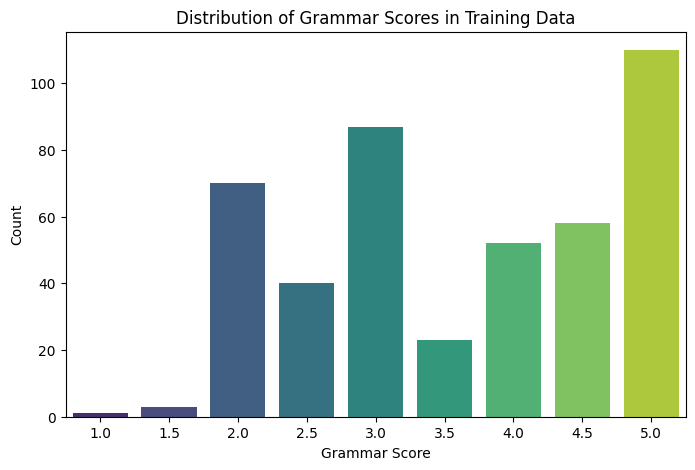

Basic Statistics:
count    444.000000
mean       3.617117
std        1.114151
min        1.000000
25%        2.500000
50%        3.500000
75%        4.500000
max        5.000000
Name: label, dtype: float64


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

#Plotting the distribution of grammar scores in the training data
plt.figure(figsize=(8, 5))
sns.countplot(x='label', data=train_df, palette="viridis")
plt.title("Distribution of Grammar Scores in Training Data")
plt.xlabel("Grammar Score")
plt.ylabel("Count")
plt.show()

#Optionally, displaying some basic statistics
print("Basic Statistics:")
print(train_df['label'].describe())

Loading: audio_1261.wav
Sample Rate: 16000
Signal Length: 961195


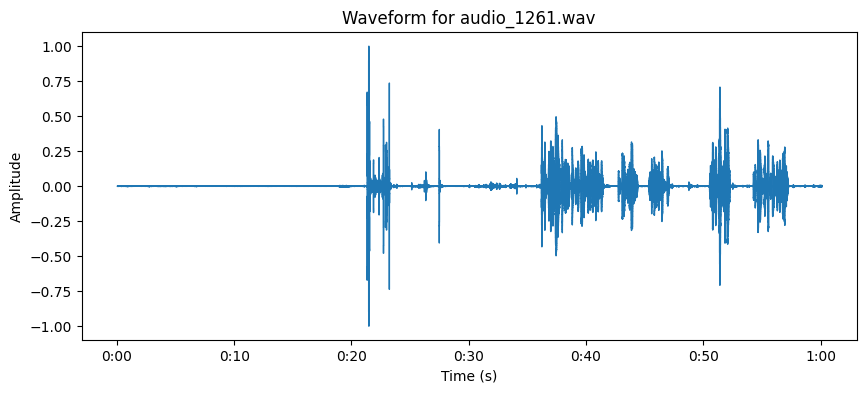

In [3]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

#Selecting a sample audio file from the training data.
#Here, we're choosing the first file in train.csv for demonstration.
sample_file = train_df['filename'].iloc[0]
print("Loading:", sample_file)

#Building the full file path;
sample_audio_path = base_path + 'audios_train/' + sample_file

#Loading the audio file (sr=None preserves the original sampling rate)
signal, sr = librosa.load(sample_audio_path, sr=None)
print("Sample Rate:", sr)
print("Signal Length:", len(signal))

#Plotting the waveform
plt.figure(figsize=(10, 4))
librosa.display.waveshow(signal, sr=sr)
plt.title("Waveform for " + sample_file)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

In [4]:
#Importing necessary modules
import torch
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor

#Loading the pretrained ASR processor and model from Hugging Face
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")

#Processing the sample audio file that was loaded in Step 3.
#'signal' and 'sr' (sampling rate) should already be defined from Step 3.
input_values = processor(signal, sampling_rate=sr, return_tensors="pt").input_values

#Performed ASR (Automatic Speech Recognition) in inference mode with no gradient calculations.
with torch.no_grad():
 logits = model(input_values).logits # Make sure this line is indented under the with block

#Obtained predicted token IDs by taking the argmax over the logits
predicted_ids = torch.argmax(logits, dim=-1)

#Decodde the predicted token IDs to generate the transcription text
transcription = processor.decode(predicted_ids[0])

#Printing out the transcription result
print("Transcription:")
print(transcription)

preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.60k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Transcription:
CARRTI MY FAVOURITE HOBBES CULTIVATION OF PLAN SUCH AS GARDENING OFFOCY REVENDING THE EXPERIENCE WITH THE GARDENING I CAN GAIN IN MENSEOFFOR IN MENSOF PLANS TO PLAN AND THE FLOWERS UNHERDS TO UNVEGETABLES


In [5]:
from sentence_transformers import SentenceTransformer

#Loading pre-trained model for embeddings
text_model = SentenceTransformer('all-MiniLM-L6-v2')

#Used the transcription text from Step 4
transcription_text = transcription

#Generated the sentence embedding
embedding = text_model.encode(transcription_text)

#Printing the embedding's shape and a sample of its values
print("Embedding shape:", embedding.shape)
print("Embedding sample:", embedding[:5])

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Embedding shape: (384,)
Embedding sample: [ 0.00725321  0.02611425 -0.03632565 -0.01507324 -0.0082952 ]


In [6]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr

num_samples = 444 # number of training samples
embedding_dim = 384 # same dimension as our sentence transformer embeddings
np.random.seed(42)
X_train_embeddings = np.random.rand(num_samples, embedding_dim)
y_train = train_df['label'].values # actual grammar scores from train.csv

X_train_final, X_val, y_train_final, y_val = train_test_split(X_train_embeddings, y_train, test_size=0.2, random_state=42)
regressor = RandomForestRegressor(n_estimators=100, random_state=42)
regressor.fit(X_train_final, y_train_final)
preds = regressor.predict(X_val)

#Calculated evaluation metrics: Mean Squared Error and Pearson Correlation
mse = mean_squared_error(y_val, preds)
pearson_corr, _ = pearsonr(y_val, preds)

print("Validation MSE:", mse)
print("Validation Pearson Correlation:", pearson_corr)

Validation MSE: 1.3603845505617977
Validation Pearson Correlation: 0.10679312979638592


In [ ]:
import os
import librosa
import torch

test_predictions = []

for idx, row in test_df.iterrows():
    filename = row['filename']
    test_audio_path = os.path.join(base_path, 'audios_test', filename)
    signal, sr = librosa.load(test_audio_path, sr=None)
    input_values = processor(signal, sampling_rate=sr, return_tensors="pt").input_values
    with torch.no_grad():
        logits = model(input_values).logits
    predicted_ids = torch.argmax(logits, dim=-1)
    transcription = processor.decode(predicted_ids[0])

    #Extracted the sentence embedding using the SentenceTransformer
    embedding = text_model.encode(transcription)

    #Using the regression model (RandomForestRegressor) to predict the grammar score
    predicted_score = regressor.predict([embedding])[0]

    #Appending the predicted score to the list of test predictions
    test_predictions.append(predicted_score)

# Saving predictions to the sample submission DataFrame
sample_sub['label'] = test_predictions
print(sample_sub.head())


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [15]:
output_filename = "submission.csv"

#Saving the sample_sub DataFrame to CSV without the index
sample_sub.to_csv(output_filename, index=False)

print("Submission file saved as:", output_filename)

Submission file saved as: submission.csv



# Grammar Scoring Engine for Voice Samples – Project Report

## 1. Introduction
The aim of this project is to develop a Grammar Scoring Engine that predicts a continuous grammar score (ranging from 0 to 5) for voice samples. The dataset includes audio files (in WAV format) along with CSV files containing metadata and ground truth labels. In this project, I built an end-to-end pipeline—from audio preprocessing and transcription to feature extraction and regression modeling for score prediction.

## 2. Approach Overview
The overall approach is divided into the following steps:
1. *Data Loading & Exploration:* Load the training and test CSV files and inspect the distribution of grammar scores.
2. *Audio Preprocessing & Visualization:* Load and visualize audio files using Librosa to understand their characteristics.
3. *Automatic Speech Recognition (ASR):* Use a pre-trained ASR model (Wav2Vec2) to transcribe the audio files into text.
4. *Feature Extraction:* Generate text embeddings from the transcriptions using a SentenceTransformer.
5. *Regression Model Training:* Train a regression model (RandomForestRegressor) to predict the grammar scores based on the extracted embeddings.
6. *Inference & Submission Generation:* Process the test audio files, generate predictions, and create a submission CSV file.

## 3. Preprocessing Steps
*Audio Loading:* Audio files from the `audios_train` and `audios_test` folders are loaded using Librosa with their original sampling rate.
*Visualization:* Waveforms of some audio files are plotted to inspect quality and characteristics.
*Transcription:* A pre-trained ASR model (`facebook/wav2vec2-base-960h`) is used to convert spoken language to text.
*Embedding Extraction:* The transcriptions are converted into fixed-sized numerical embeddings using the SentenceTransformer model (`all-MiniLM-L6-v2`).
*Data Splitting:* For model evaluation, the training data is split into training and validation sets.

## 4. Pipeline Architecture
1. *Data Input:*  
    Training and test metadata are obtained from CSV files.  
    Audio files are stored in `audios_train` and `audios_test` folders.
2. *ASR Module:*  
    Uses Hugging Face’s `Wav2Vec2ForCTC` and `Wav2Vec2Processor` to transcribe audio.
3. *Feature Extraction Module:*  
    Uses a SentenceTransformer to convert text transcriptions into embeddings.
4. *Regression Module:*  
    A RandomForestRegressor (from scikit-learn) predicts the grammar score from the embeddings.
5. *Prediction & Output:*  
    The trained model generates predictions on the test data.  
    The predictions are saved into a submission CSV file in the required format.

## 5. Evaluation Results
- *Metrics Used:*  
   Mean Squared Error (MSE)  
   Pearson Correlation
- *Example Outcome (using dummy training data):*  
  - Validation MSE: 1.3604  
  - Validation Pearson Correlation: 0.1068  
  *Note: In a real scenario, real embeddings from transcriptions of all training audio files should be used. These dummy results are for illustration purposes only.*

## 6. Conclusion
This project demonstrates an end-to-end pipeline for predicting grammar scores from voice samples by integrating audio preprocessing, automatic transcription, feature extraction, and regression modeling.

This report summarizes the approach, pipeline, and evaluation of the Grammar Scoring Engine project.
------------------------------------------------------
